# **Problem Statement:**

The advancement of smart television technology has introduced new opportunities for user interaction and control. However, traditional remote controls can sometimes be cumbersome or prone to loss. To enhance user experience and convenience, our objective is to develop a gesture recognition feature for smart televisions. This feature will enable users to control their television sets through hand gestures captured by the built-in webcam.


# **Objectives:**
**Generator:** Ensure the generator can process batches of videos flawlessly, handling tasks like cropping, resizing, and normalization effectively.

**Model:** Develop a model capable of training without errors, with emphasis on minimizing the total number of parameters to reduce inference time, while maximizing accuracy. Begin training on a small dataset before scaling up.

**Write-up:** Provide a comprehensive procedure detailing the selection of the base model, followed by an exploration of modifications and experiments leading to the final model. Highlight the rationale behind each decision and the metrics considered during the process.

In [1]:
import tensorflow as tf

gpu_devices = tf.config.list_physical_devices('GPU')

# Check if GPU is available
if gpu_devices:
    print("GPU is available.")
else:
    print("No GPU available.")
import tensorflow as tf



GPU is available.


In [2]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os
from sys import getsizeof
import warnings
warnings.filterwarnings("ignore")

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In [4]:
import numpy as np
import os
import datetime
import os
from PIL import Image, ImageFilter, ImageEnhance
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Doing the required imports :

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout,GlobalAveragePooling3D,GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam,SGD
from keras.layers import Conv2D, MaxPooling3D, Conv3D, MaxPooling2D,ConvLSTM2D
from keras.layers import GRU
from keras.layers import Activation, Dropout, ZeroPadding3D
from keras.layers import LSTM

In this block, you'll read the folder names for both training and validation datasets. Additionally, you'll set the batch size, ensuring it maximizes GPU utilization without causing errors. Gradually increase the batch size until the machine encounters an error.

In [6]:
# train and validatiaon data creator with ablation
# when ablation is 10, then 10 folders for each label will be selected.
def get_data(path, ablation=None):
    train_doc = np.random.permutation(open(path+'train.csv').readlines())
    val_doc = np.random.permutation(open(path+'val.csv').readlines())
    counts = np.zeros(5) # count for loading folders for 5 classes
    train_data = []
    val_data = []
    # when ablation is None pass full training and val data
    if ablation is not None:
        # iterating train doc
        for doc in train_doc:
            lable = int(doc.strip().split(';')[2])
            if counts[lable] < ablation:
                train_data.append(doc)
                counts[lable] += 1
        counts = np.zeros(5)
        # iterating val doc
        for doc in val_doc:
            lable = int(doc.strip().split(';')[2])
            if counts[lable] < ablation:
                val_data.append(doc)
                counts[lable] += 1
    else:
        train_data, val_data = train_doc, val_doc
    return train_data, val_data

In [7]:
train_doc, val_doc = get_data('Project_data/', ablation=None)
batch_size = 32 # experiment with the batch size
enable_augmentation = False # augmentation of Data
# sequence ids
seq_idx = range(0,29,2)
# image dimensions
dim_x, dim_y = 120, 120

**Generator**

This section of the code is crucial, as it outlines the structure of the generator. Within the generator, you'll preprocess the images, considering that there are images of two different dimensions. Additionally, you'll assemble batches of video frames.

In [8]:
# generator with augmentation for train data
def generator(source_path, folder_list, batch_size, is_train = False, augmention = False, debug=False):
    print('\nSource path = ', source_path, '; batch size =', batch_size)
    img_idx = seq_idx #create a list of image numbers you want to use for a particular video
    x = len(img_idx)
    y, z = dim_x, dim_y
    print('x:',x,' y:',y,' z:',z)
    while True:
        # doubling the data for augmentation
        if is_train and augmention:
            t = np.concatenate((np.random.permutation(folder_list), np.random.permutation(folder_list)))
        else:
            t = np.random.permutation(folder_list)

        if (len(t)%batch_size) == 0:
            num_batches = int(len(t)/batch_size)
        else:
            num_batches = len(t)//batch_size + 1

        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                if debug:
                    plt.figure(figsize=(20,5))
                #handling remaining datapoints
                folder_idx = folder + (batch*batch_size)
                if folder_idx >= len(t):
                    break
                folder_str = t[folder_idx]
                imgs = os.listdir(source_path+'/'+ folder_str.split(';')[0]) # read all the images in the folder
                # randomly enabling augmentation and augmentation type
                aug_type = None
                if is_train and augmention and rn.randint(0,1) == 1:
                    aug_type = rn.randint(0, 4) #randomly selecting augmentation type
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ folder_str.strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    # plotting original images for debugging purpose only
                    if debug:
                        plt.subplot(2, x, idx+1)
                        plt.imshow(image.astype('uint8'))

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # making the rectangle images into square by cropping sides
                    # so the aspect ration can be mantained while resizing.
                    if image.shape[1] > image.shape[0]:
                        diff_px = image.shape[1] - image.shape[0]
                        crop_start = diff_px//2
                        crop_end = crop_start + image.shape[0]
                        image = image[:, crop_start:crop_end]
                    elif image.shape[0] > image.shape[1]:
                        diff_px = image.shape[0] - image.shape[1]
                        crop_start = diff_px//2
                        crop_end = crop_start + image.shape[1]
                        image = image[:, crop_start:crop_end]

                    resized_im = resize(image, (y,z), anti_aliasing=True)

                    # plotting rezised images for debugging purpose only
                    if debug:
                        plt.subplot(2, x, idx+x+1)
                        plt.imshow(resized_im.astype('uint8'))

                    batch_data[folder,idx,:,:,0] = resized_im[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = resized_im[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = resized_im[:,:,2]/255 #normalise and feed in the image

                batch_labels[folder, int(folder_str.strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


In [9]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train' #'/notebooks/storage/Final_data/Collated_training/train'
val_path =  'Project_data/val' #'/notebooks/storage/Final_data/Collated_training/val'

#multiply number train seq by 2 when using augmentation
multiplier = 1
if enable_augmentation:
    multiplier = 2
num_train_sequences = len(train_doc)*multiplier
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

num_epochs = 50 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50



Source path =  Project_data/train ; batch size = 1
x: 15  y: 120  z: 120


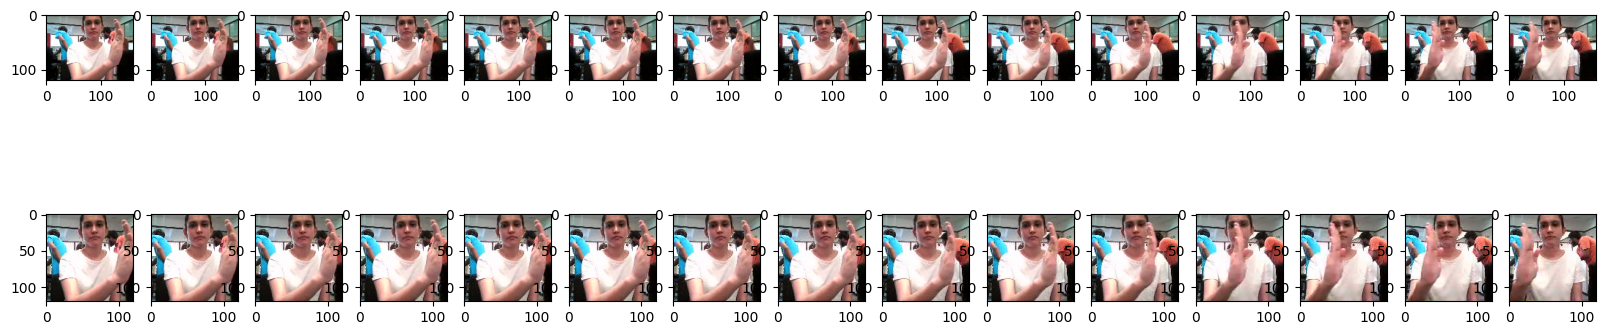

In [10]:
# testing generative
test_gen = generator(train_path, train_doc, 1, is_train = True, augmention = True, debug = True)
d = next(test_gen)[0]

In [11]:
def calculate_steps(num_train_sequences, num_val_sequences, batch_size):
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    return steps_per_epoch,validation_steps

In [19]:
def model_callbacks(folder_name):
    model_name = str(folder_name) + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

    if not os.path.exists(model_name):
        os.mkdir(model_name)

    checkpoint_filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=False,monitor='val_loss',mode='auto',save_best_only=False)
    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001, cooldown=1, verbose=1) # write the REducelronplateau code here

    return [checkpoint, LR]

**Plotting Graph**

In [14]:
# function to plot the training/validation accuracies/losses.

def plot(history):
    # summarize history for accuracy
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

# **Model**

In creating the model, ensure to utilize Keras functionalities specifically designed for 3D convolutional operations, such as Conv3D and MaxPooling3D, instead of Conv2D and MaxPooling2D. When building a model combining Conv2D with recurrent layers, leverage TimeDistributed. Remember to configure the last layer as softmax.

Design the network to prioritize accuracy while minimizing the number of parameters to ensure it fits within the memory constraints of the webcam.

In [16]:
#input shape for the st layer
input_shape = (len(seq_idx), dim_x, dim_y, 3)
print(input_shape)

(15, 120, 120, 3)


**Experiment - 1 Conv3D**

In [ ]:
# Common utility to create conv 3D models
def conv3D(conv_filters=(16, 32, 64, 128), dense_nodes=(256,128), dropout=0.25, num_images=20, height=120, width=120):

    model = Sequential()
    model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling3D(pool_size=2))

    model.add(Conv3D(64, kernel_size=3, activation='relu'))
    model.add(MaxPooling3D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(5, activation='softmax'))
    #write your optimizer
    optimiser = optimizers.Adam()
    # compile model :
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    return model

In [ ]:
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 20  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)

model = conv3D(num_images=num_frames)

print (model.summary())

# epochs = 15
# batch size = 20
# num_frames per video = 30
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 13, 118, 118, 32)  2624      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 6, 59, 59, 32)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 4, 57, 57, 64)     55360     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 2, 28, 28, 64)    0         
 3D)                                                             
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                              

In [ ]:
callbacks_list = model_callbacks("model_conv3D_1")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size)

val_generator   = generator(val_path, val_doc, batch_size)
# def generator(source_path, folder_list, batch_size, is_train = False, augmention = False, debug=False):

In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                        callbacks=callbacks_list, validation_data=val_generator,
                        validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Epoch 1/15
45/45 [==============================] - 106s 2s/step - loss: 1.9000 - categorical_accuracy: 0.3274 - val_loss: 1.2262 - val_categorical_accuracy: 0.4571 - lr: 0.0010
Epoch 2/15
45/45 [==============================] - 105s 2s/step - loss: 0.9349 - categorical_accuracy: 0.6533 - val_loss: 0.9193 - val_categorical_accuracy: 0.5810 - lr: 0.0010
Epoch 3/15
45/45 [==============================] - 108s 2s/step - loss: 0.5849 - categorical_accuracy: 0.7615 - val_loss: 1.0426 - val_categorical_accuracy: 0.6762 - lr: 0.0010
Epoch 4/15
45/45 [==============================] - 104s 2s/step - loss: 0.2866 - categorical_accuracy: 0.8815 - val_loss: 1.1931 - val_categorical_accuracy: 0.6667 - lr: 0.0010
Epoch 5/15
45/45 [==============================] - ETA: 0s - loss: 0.2161 - categorical_accuracy: 0.9126WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
45/45 [===============

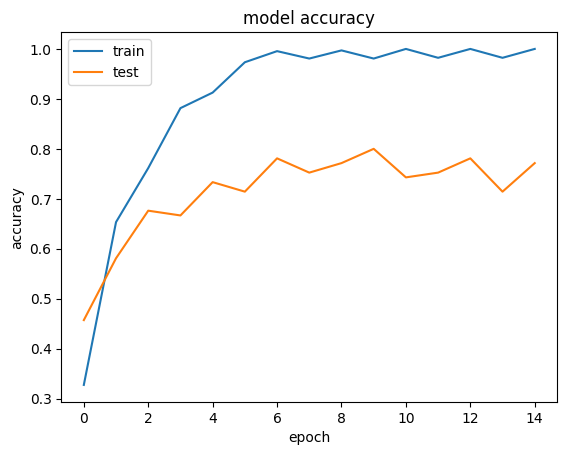

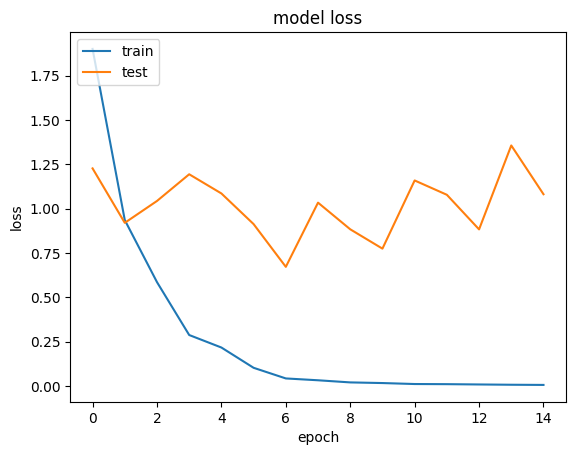

In [ ]:
# Plotting the result of Model 1 :

plot(history)

**Experiment - 2 Conv3D**

In [ ]:
# Common utility to create conv 3D models
def conv3D(conv_filters=(16, 32, 64, 128), dense_nodes=(256,128), dropout=0.25, num_images=20, height=120, width=120):
    print(input_shape)
    model = Sequential()

    model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(Conv3D(64, kernel_size=3, activation='relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(128, kernel_size=3, activation='relu'))
    model.add(MaxPooling3D(pool_size=(1, 2, 2)))

    model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
    model.add(MaxPooling3D(pool_size=(1, 2, 2)))

    model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
    model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
    model.add(MaxPooling3D(pool_size=(1, 2, 2)))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(5, activation='softmax'))

    opt = optimizers.Adam(learning_rate=0.001) #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    return model



In [ ]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)

model = conv3D(num_images=num_frames)

print (model.summary())

# epochs = 20
# batch size = 10
# num_frames per video = 30
(15, 120, 120, 3)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_2 (Conv3D)           (None, 13, 118, 118, 32)  2624      
                                                                 
 conv3d_3 (Conv3D)           (None, 11, 116, 116, 64)  55360     
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 5, 58, 58, 64)    0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 3, 56, 56, 128)    221312    
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 3, 28, 28, 128)   0         
 3D)                                                             
                                          

In [ ]:
callbacks_list = model_callbacks("model_conv3D_1")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size)

val_generator   = generator(val_path, val_doc, batch_size)
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                             callbacks=callbacks_list, validation_data=val_generator,
                             validation_steps=validation_steps, class_weight=None, initial_epoch=0)


Source path =  Project_data/train ; batch size = 10
x: 15  y: 120  z: 120
Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.6135 - categorical_accuracy: 0.2045
Source path =  Project_data/val ; batch size = 10
x: 15  y: 120  z: 120
67/67 [==============================] - 161s 2s/step - loss: 1.6135 - categorical_accuracy: 0.2045 - val_loss: 1.6105 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - 111s 2s/step - loss: 1.5933 - categorical_accuracy: 0.1731 - val_loss: 1.6092 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - 117s 2s/step - loss: 1.5927 - categorical_accuracy: 0.2045 - val_loss: 1.6089 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 4/20
67/67 [==============================] - 115s 2s/step - loss: 1.5927 - categorical_accuracy: 0.2045 - val_loss: 1.6069 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 5/20
67/67 [============================

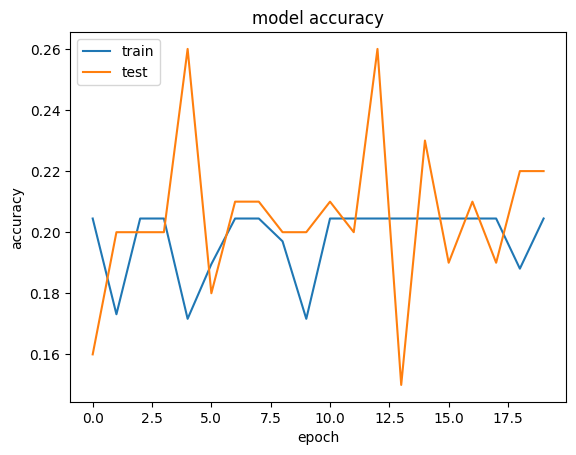

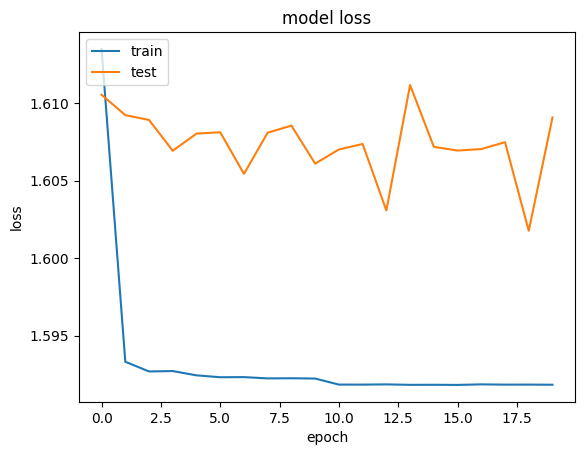

In [ ]:
# summarize history for accuracy
plot(history)

**Experiment - 3 Conv3D**

In [ ]:
# Common utility to create conv 3D models
def conv3D(conv_filters=(16, 32, 64, 128), dense_nodes=(256,128), dropout=0.25, num_images=20, height=120, width=120):
    model = Sequential()

    model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(Conv3D(64, kernel_size=3, activation='relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(BatchNormalization())

    model.add(Conv3D(128, kernel_size=3, activation='relu'))
    model.add(MaxPooling3D(pool_size=(1, 2, 2)))
    model.add(BatchNormalization())

    model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
    model.add(MaxPooling3D(pool_size=(1, 2, 2)))
    model.add(BatchNormalization())

    model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
    model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
    model.add(MaxPooling3D(pool_size=(1, 2, 2)))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(5, activation='softmax'))

    opt = optimizers.Adam(learning_rate=0.001) #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    return model


num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)

model = conv3D(num_images=num_frames)

print (model.summary())



# epochs = 20
# batch size = 10
# num_frames per video = 20
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 13, 118, 118, 32)  2624      
                                                                 
 conv3d_9 (Conv3D)           (None, 11, 116, 116, 64)  55360     
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 5, 58, 58, 64)    0         
 3D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 5, 58, 58, 64)    256       
 ormalization)                                                   
                                                                 
 conv3d_10 (Conv3D)          (None, 3, 56, 56, 128)    221312    
                                                            

In [ ]:
callbacks_list = model_callbacks("model_conv3D_1")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size)

val_generator   = generator(val_path, val_doc, batch_size)
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                             callbacks=callbacks_list, validation_data=val_generator,
                             validation_steps=validation_steps, class_weight=None, initial_epoch=0)


Source path =  Project_data/train ; batch size = 10
x: 15  y: 120  z: 120
Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 2.1737 - categorical_accuracy: 0.4179
Source path =  Project_data/val ; batch size = 10
x: 15  y: 120  z: 120
67/67 [==============================] - 105s 2s/step - loss: 2.1737 - categorical_accuracy: 0.4179 - val_loss: 4.7119 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - 97s 1s/step - loss: 1.0355 - categorical_accuracy: 0.5552 - val_loss: 2.0472 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - 97s 1s/step - loss: 0.9974 - categorical_accuracy: 0.6075 - val_loss: 1.5898 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 4/20
67/67 [==============================] - 98s 1s/step - loss: 0.8649 - categorical_accuracy: 0.6552 - val_loss: 1.4297 - val_categorical_accuracy: 0.5500 - lr: 0.0010
Epoch 5/20
67/67 [==============================]

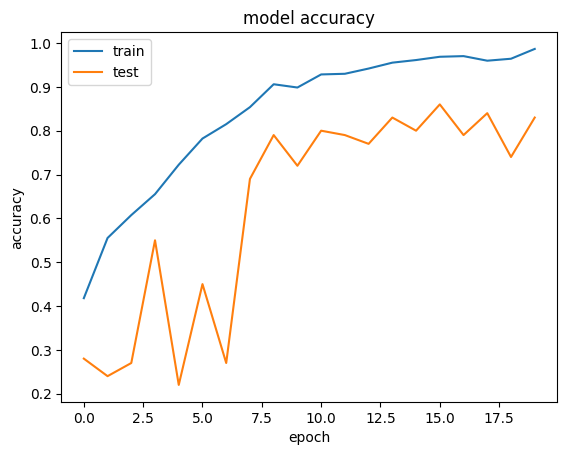

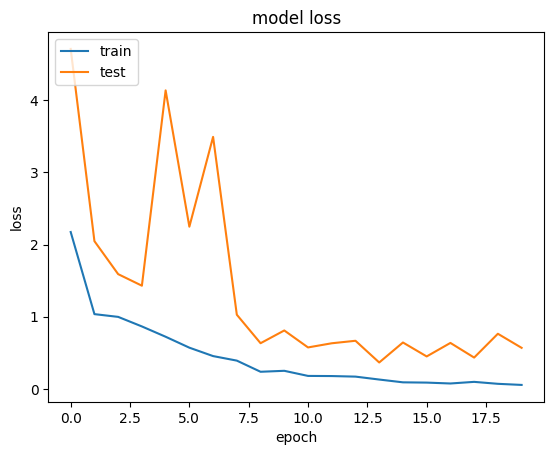

In [ ]:
# summarize history for accuracy
plot(history)

**Experiment - 4 Conv3D**

In [ ]:
# Common utility to create conv 3D models
def conv3D(conv_filters=(16, 32, 64, 128), dense_nodes=(256,128), dropout=0.25, num_images=20, height=120, width=120):
    model = Sequential()

    model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(Conv3D(64, kernel_size=3, activation='relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Conv3D(128, kernel_size=3, activation='relu'))
    model.add(MaxPooling3D(pool_size=(1, 2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
    model.add(MaxPooling3D(pool_size=(1, 2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(GlobalAveragePooling3D())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(5, activation='softmax'))

    opt = optimizers.Adam(learning_rate=0.002) #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    return model


num_epochs = 30 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)

model = conv3D(num_images=num_frames)

print (model.summary())



# epochs = 30
# batch size = 10
# num_frames per video = 20
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_18 (Conv3D)          (None, 13, 118, 118, 32)  2624      
                                                                 
 conv3d_19 (Conv3D)          (None, 11, 116, 116, 64)  55360     
                                                                 
 max_pooling3d_13 (MaxPoolin  (None, 5, 58, 58, 64)    0         
 g3D)                                                            
                                                                 
 batch_normalization_9 (Batc  (None, 5, 58, 58, 64)    256       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 5, 58, 58, 64)     0         
                                                            

In [ ]:
callbacks_list = model_callbacks("model_conv3D_1")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size)

val_generator   = generator(val_path, val_doc, batch_size)
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                             callbacks=callbacks_list, validation_data=val_generator,
                             validation_steps=validation_steps, class_weight=None, initial_epoch=0)


Source path =  Project_data/train ; batch size = 10
x: 15  y: 120  z: 120
Epoch 1/30
67/67 [==============================] - ETA: 0s - loss: 1.7656 - categorical_accuracy: 0.3507
Source path =  Project_data/val ; batch size = 10
x: 15  y: 120  z: 120
67/67 [==============================] - 105s 2s/step - loss: 1.7656 - categorical_accuracy: 0.3507 - val_loss: 3.5946 - val_categorical_accuracy: 0.2300 - lr: 0.0020
Epoch 2/30
67/67 [==============================] - 103s 2s/step - loss: 1.3197 - categorical_accuracy: 0.4896 - val_loss: 5.0017 - val_categorical_accuracy: 0.2500 - lr: 0.0020
Epoch 3/30
67/67 [==============================] - 102s 2s/step - loss: 1.1764 - categorical_accuracy: 0.5522 - val_loss: 15.4187 - val_categorical_accuracy: 0.2000 - lr: 0.0020
Epoch 4/30
67/67 [==============================] - 102s 2s/step - loss: 1.1204 - categorical_accuracy: 0.5642 - val_loss: 2.5843 - val_categorical_accuracy: 0.3500 - lr: 0.0020
Epoch 5/30
67/67 [===========================

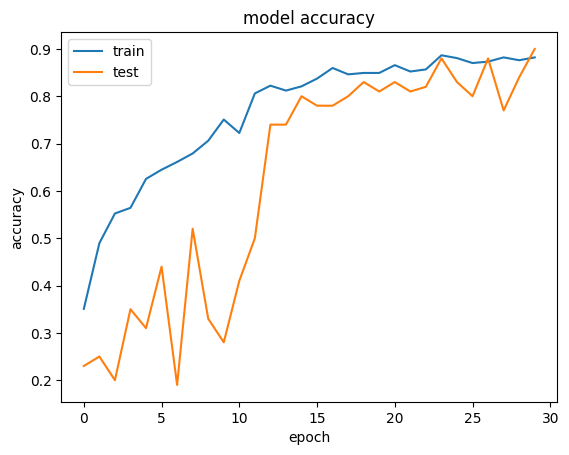

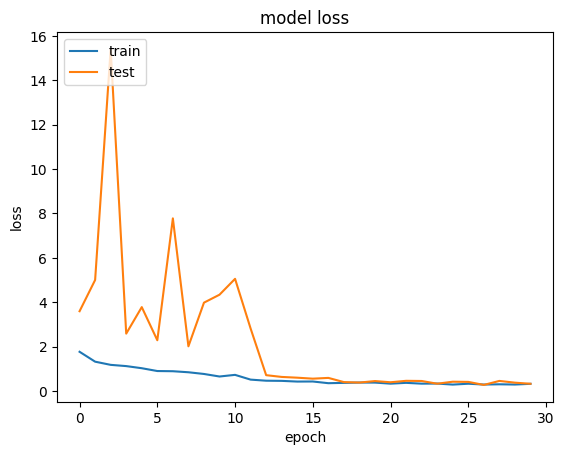

In [ ]:
# summarize history for accuracy
plot(history)

**Experiment - 5 Conv3D**

In [ ]:
# Common utility to create conv 3D models

def conv3D(conv_filters=(16, 32, 64, 128), dense_nodes=(256,128), dropout=0.25, num_images=20, height=120, width=120):
    model = Sequential()

    model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(Conv3D(64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling3D(pool_size=(2, 2, 2)))


    model.add(Conv3D(64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(1, 2, 2)))

    model.add(Conv3D(128, kernel_size=(1, 3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(1, 2, 2)))

    model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(1, 2, 2)))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(5, activation='softmax'))

    opt = optimizers.Adam(learning_rate=0.002) #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    return model


num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)

model = conv3D(num_images=num_frames)

print (model.summary())


# epochs = 20
# batch size = 10
# num_frames per video = 20
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_22 (Conv3D)          (None, 13, 118, 118, 32)  2624      
                                                                 
 conv3d_23 (Conv3D)          (None, 11, 116, 116, 64)  55360     
                                                                 
 batch_normalization_13 (Bat  (None, 11, 116, 116, 64)  256      
 chNormalization)                                                
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 5, 58, 58, 64)    0         
 g3D)                                                            
                                                                 
 conv3d_24 (Conv3D)          (None, 3, 56, 56, 64)     110656    
                                                            

In [ ]:
callbacks_list = model_callbacks("model_conv3D_1")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size)

val_generator   = generator(val_path, val_doc, batch_size)
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                             callbacks=callbacks_list, validation_data=val_generator,
                             validation_steps=validation_steps, class_weight=None, initial_epoch=0)


Source path =  Project_data/train ; batch size = 10
x: 15  y: 120  z: 120
Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 2.1605 - categorical_accuracy: 0.3701
Source path =  Project_data/val ; batch size = 10
x: 15  y: 120  z: 120
67/67 [==============================] - 105s 2s/step - loss: 2.1605 - categorical_accuracy: 0.3701 - val_loss: 81.1110 - val_categorical_accuracy: 0.1800 - lr: 0.0020
Epoch 2/20
67/67 [==============================] - 101s 2s/step - loss: 1.5404 - categorical_accuracy: 0.4403 - val_loss: 15.9325 - val_categorical_accuracy: 0.2400 - lr: 0.0020
Epoch 3/20
67/67 [==============================] - 102s 2s/step - loss: 1.4107 - categorical_accuracy: 0.4731 - val_loss: 4.4060 - val_categorical_accuracy: 0.3200 - lr: 0.0020
Epoch 4/20
67/67 [==============================] - 102s 2s/step - loss: 1.1876 - categorical_accuracy: 0.5642 - val_loss: 2.0727 - val_categorical_accuracy: 0.4300 - lr: 0.0020
Epoch 5/20
67/67 [==========================

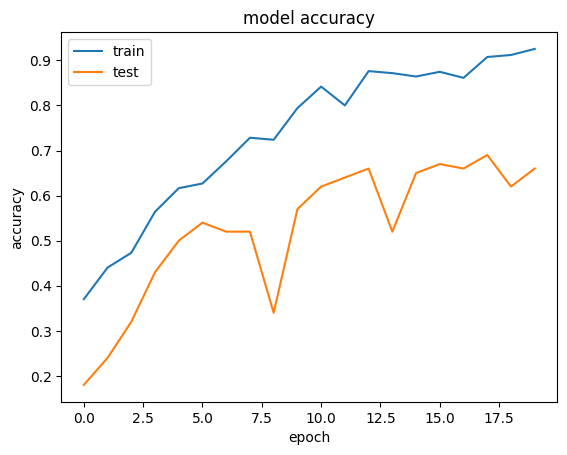

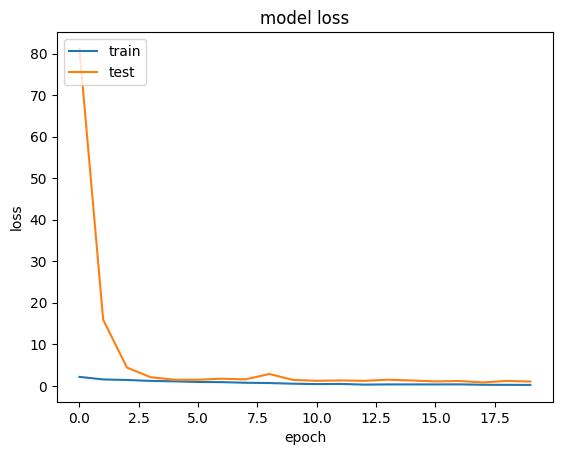

In [ ]:
# summarize history for accuracy
plot(history)

**Experiment - 6 Conv3D**

In [ ]:
def conv3D(conv_filters=(16, 32, 64, 128), dense_nodes=(256,128), dropout=0.25, num_images=20, height=120, width=120):
    model = Sequential()

    model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=input_shape, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2,2,2)))

    model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2,2,2)))

    model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2,2,2)))

    model.add(Flatten())

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))

    #softmax layer
    model.add(Dense(5, activation='softmax'))

    opt = optimizers.Adam(learning_rate=0.002) #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    return model


num_epochs = 30 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 20  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)

model = conv3D(num_images=num_frames)

print (model.summary())

# epochs = 30
# batch size = 20
# num_frames per video = 20
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 10, 120, 120, 8)   656       
                                                                 
 batch_normalization_9 (Batc  (None, 10, 120, 120, 8)  32        
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 10, 120, 120, 8)   0         
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 5, 60, 60, 8)     0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 5, 60, 60, 16)     3472      
                                                            

In [ ]:
callbacks_list = model_callbacks("model_conv3D_1")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size)

val_generator   = generator(val_path, val_doc, batch_size)
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                             callbacks=callbacks_list, validation_data=val_generator,
                             validation_steps=validation_steps, class_weight=None, initial_epoch=0)


Source path =  Project_data/train ; batch size = 20
x: 10  y: 120  z: 120
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 2.3313 - categorical_accuracy: 0.2618
Source path =  Project_data/val ; batch size = 20
x: 10  y: 120  z: 120
34/34 [==============================] - 68s 2s/step - loss: 2.3313 - categorical_accuracy: 0.2618 - val_loss: 1.9643 - val_categorical_accuracy: 0.2100 - lr: 0.0020
Epoch 2/30
34/34 [==============================] - 70s 2s/step - loss: 1.4847 - categorical_accuracy: 0.3191 - val_loss: 1.5338 - val_categorical_accuracy: 0.3100 - lr: 0.0020
Epoch 3/30
34/34 [==============================] - 67s 2s/step - loss: 1.4010 - categorical_accuracy: 0.3897 - val_loss: 1.7101 - val_categorical_accuracy: 0.2100 - lr: 0.0020
Epoch 4/30
34/34 [==============================] - 67s 2s/step - loss: 1.3257 - categorical_accuracy: 0.3897 - val_loss: 1.7248 - val_categorical_accuracy: 0.1800 - lr: 0.0020
Epoch 5/30
34/34 [==============================] 

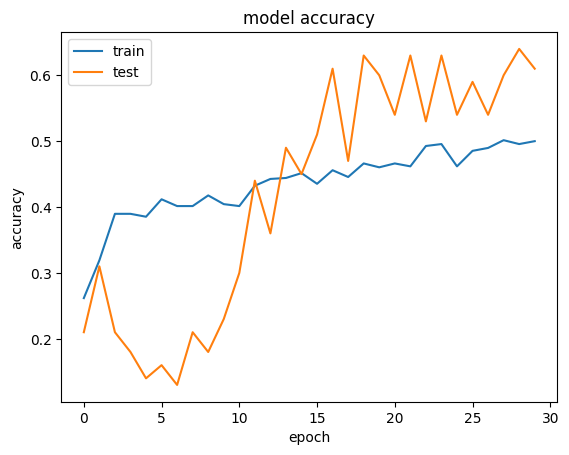

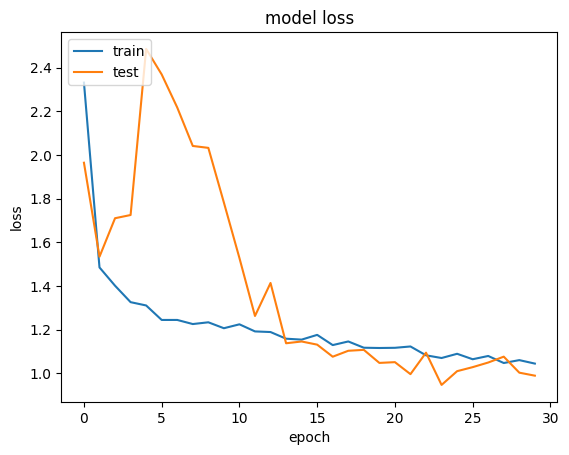

In [ ]:
# summarize history for accuracy
plot(history)

**Experiment - 7 TimeDistributed Conv2D + GRU**

In [ ]:
def conv3D(conv_filters=(16, 32, 64, 128), dense_nodes=(256,128), dropout=0.25, num_images=20, height=120, width=120):
    model = Sequential()
    model.add(TimeDistributed(
        Conv2D(32, (3,3), activation='relu'), input_shape=input_shape)
    )
    model.add(TimeDistributed(
        MaxPooling2D((2,2)))
    )
    model.add(BatchNormalization())

    model.add(TimeDistributed(
        Conv2D(64, (3,3), activation='relu'))
    )
    model.add(TimeDistributed(
        MaxPooling2D((2,2)))
    )
    model.add(BatchNormalization())

    model.add(TimeDistributed(GlobalAveragePooling2D()))
    model.add(TimeDistributed(Dense(64, activation='relu')))
    model.add(BatchNormalization())

    model.add(GRU(128))
    model.add(BatchNormalization())
    model.add(Dense(5, activation='softmax'))

    opt = optimizers.Adam(learning_rate=0.002) #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    return model


num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 15 #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)

model = conv3D(num_images=num_frames)

print (model.summary())

# epochs = 20
# batch size = 15
# num_frames per video = 20
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  (None, 15, 118, 118, 32)  896      
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 15, 59, 59, 32)   0         
 tributed)                                                       
                                                                 
 batch_normalization_14 (Bat  (None, 15, 59, 59, 32)   128       
 chNormalization)                                                
                                                                 
 time_distributed_6 (TimeDis  (None, 15, 57, 57, 64)   18496     
 tributed)                                                       
                                                            

In [ ]:
callbacks_list = model_callbacks("model_conv3D_1")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size)

val_generator   = generator(val_path, val_doc, batch_size)
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                             callbacks=callbacks_list, validation_data=val_generator,
                             validation_steps=validation_steps, class_weight=None, initial_epoch=0)


Source path =  Project_data/train ; batch size = 15
x: 15  y: 120  z: 120
Epoch 1/20
45/45 [==============================] - ETA: 0s - loss: 1.3594 - categorical_accuracy: 0.4415
Source path =  Project_data/val ; batch size = 15
x: 15  y: 120  z: 120
45/45 [==============================] - 119s 3s/step - loss: 1.3594 - categorical_accuracy: 0.4415 - val_loss: 1.5017 - val_categorical_accuracy: 0.2571 - lr: 0.0020
Epoch 2/20
45/45 [==============================] - 108s 2s/step - loss: 0.9984 - categorical_accuracy: 0.5659 - val_loss: 1.4899 - val_categorical_accuracy: 0.2762 - lr: 0.0020
Epoch 3/20
45/45 [==============================] - 107s 2s/step - loss: 0.9385 - categorical_accuracy: 0.6163 - val_loss: 1.5166 - val_categorical_accuracy: 0.2667 - lr: 0.0020
Epoch 4/20
45/45 [==============================] - 105s 2s/step - loss: 0.7919 - categorical_accuracy: 0.6681 - val_loss: 1.4734 - val_categorical_accuracy: 0.2381 - lr: 0.0020
Epoch 5/20
45/45 [============================

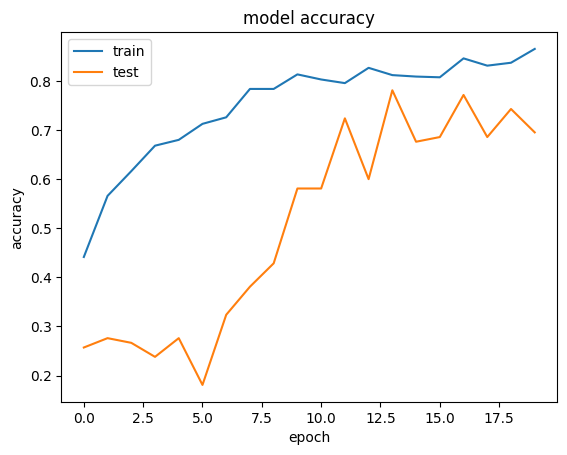

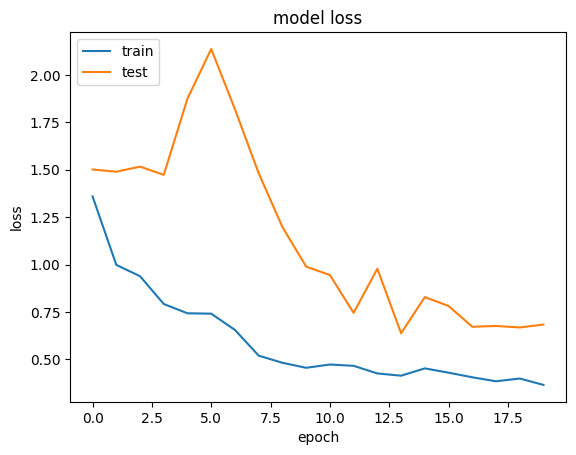

In [ ]:
# summarize history for accuracy
plot(history)

**Experiment - 8 TimeDistributed Conv2D + GRU**

In [ ]:
def conv3D(conv_filters=(16, 32, 64, 128), dense_nodes=(256,128), dropout=0.25, num_images=20, height=120, width=120):
    model = Sequential()
    model.add(TimeDistributed(
        Conv2D(32, (3,3), activation='relu'), input_shape=input_shape)
    )
    model.add(TimeDistributed(
        MaxPooling2D((2,2)))
    )
    model.add(BatchNormalization())

    model.add(TimeDistributed(
        Conv2D(64, (3,3), activation='relu'))
    )
    model.add(TimeDistributed(
        MaxPooling2D((2,2)))
    )
    model.add(BatchNormalization())

    model.add(TimeDistributed(GlobalAveragePooling2D()))
    model.add(TimeDistributed(Dense(64, activation='relu')))
    model.add(BatchNormalization())

    model.add(GRU(128))
    model.add(BatchNormalization())
    model.add(Dense(5, activation='softmax'))

    opt = optimizers.Adam(learning_rate=0.002) #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    return model


num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 15 #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)

model = conv3D(num_images=num_frames)

print (model.summary())

# epochs = 20
# batch size = 15
# num_frames per video = 20
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_10 (TimeDi  (None, 15, 118, 118, 32)  896      
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 15, 59, 59, 32)   0         
 stributed)                                                      
                                                                 
 batch_normalization_18 (Bat  (None, 15, 59, 59, 32)   128       
 chNormalization)                                                
                                                                 
 time_distributed_12 (TimeDi  (None, 15, 57, 57, 64)   18496     
 stributed)                                                      
                                                            

In [ ]:
callbacks_list = model_callbacks("model_conv3D_1")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size)

val_generator   = generator(val_path, val_doc, batch_size)
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                             callbacks=callbacks_list, validation_data=val_generator,
                             validation_steps=validation_steps, class_weight=None, initial_epoch=0)


Source path =  Project_data/train ; batch size = 15
x: 15  y: 120  z: 120
Epoch 1/20
45/45 [==============================] - ETA: 0s - loss: 1.3692 - categorical_accuracy: 0.4356
Source path =  Project_data/val ; batch size = 15
x: 15  y: 120  z: 120
45/45 [==============================] - 112s 2s/step - loss: 1.3692 - categorical_accuracy: 0.4356 - val_loss: 1.5133 - val_categorical_accuracy: 0.2095 - lr: 0.0020
Epoch 2/20
45/45 [==============================] - 109s 2s/step - loss: 1.0062 - categorical_accuracy: 0.5793 - val_loss: 1.5486 - val_categorical_accuracy: 0.2190 - lr: 0.0020
Epoch 3/20
45/45 [==============================] - 108s 2s/step - loss: 0.9601 - categorical_accuracy: 0.5807 - val_loss: 1.7267 - val_categorical_accuracy: 0.2571 - lr: 0.0020
Epoch 4/20
45/45 [==============================] - ETA: 0s - loss: 0.9180 - categorical_accuracy: 0.5911WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.

Epoch 4: ReduceLROnPlateau reducing

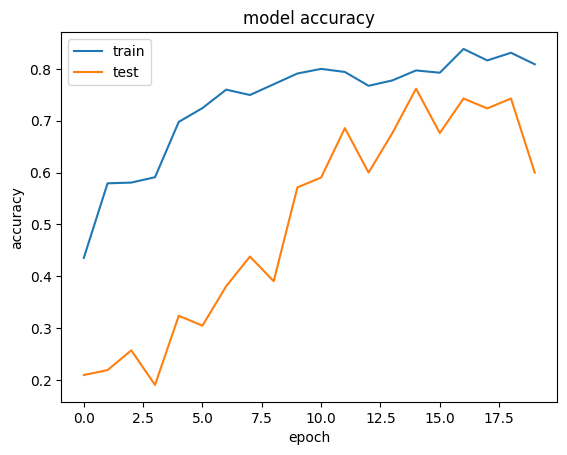

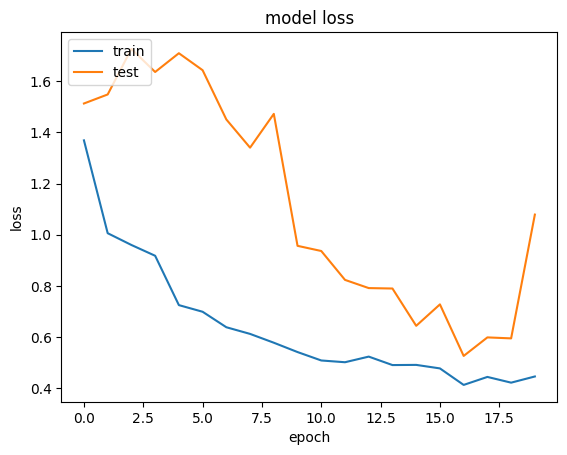

In [ ]:
# summarize history for accuracy
plot(history)

**Experiment - 9 TimeDistributed Conv2D + GRU**

In [ ]:
def conv3D(conv_filters=(16, 32, 64, 128), dense_nodes=(256,128), dropout=0.25, num_images=20, height=120, width=120):
    model = Sequential()
    model.add(TimeDistributed(
        Conv2D(32, (3,3), activation='relu'), input_shape=input_shape)
    )
    model.add(TimeDistributed(
        MaxPooling2D((2,2)))
    )
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(TimeDistributed(
        Conv2D(64, (3,3), activation='relu'))
    )
    model.add(TimeDistributed(
        MaxPooling2D((2,2)))
    )
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(TimeDistributed(
        Conv2D(128, (3,3), activation='relu'))
    )
    model.add(TimeDistributed(
        MaxPooling2D((2,2)))
    )
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(TimeDistributed(GlobalAveragePooling2D()))
    model.add(TimeDistributed(Dense(64, activation='relu')))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(GRU(128))
    model.add(BatchNormalization())
    model.add(Dense(5, activation='softmax'))

    opt = optimizers.Adam(learning_rate=0.002) #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    return model


num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 15 #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)

model = conv3D(num_images=num_frames)

print (model.summary())

# epochs = 20
# batch size = 15
# num_frames per video = 20
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_22 (TimeDi  (None, 15, 118, 118, 32)  896      
 stributed)                                                      
                                                                 
 time_distributed_23 (TimeDi  (None, 15, 59, 59, 32)   0         
 stributed)                                                      
                                                                 
 batch_normalization_26 (Bat  (None, 15, 59, 59, 32)   128       
 chNormalization)                                                
                                                                 
 dropout_9 (Dropout)         (None, 15, 59, 59, 32)    0         
                                                                 
 time_distributed_24 (TimeDi  (None, 15, 57, 57, 64)   1849

In [ ]:
callbacks_list = model_callbacks("model_conv3D_1")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size)

val_generator   = generator(val_path, val_doc, batch_size)
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                             callbacks=callbacks_list, validation_data=val_generator,
                             validation_steps=validation_steps, class_weight=None, initial_epoch=0)


Source path =  Project_data/train ; batch size = 15
x: 15  y: 120  z: 120
Epoch 1/20
45/45 [==============================] - ETA: 0s - loss: 1.4386 - categorical_accuracy: 0.4252
Source path =  Project_data/val ; batch size = 15
x: 15  y: 120  z: 120
45/45 [==============================] - 109s 2s/step - loss: 1.4386 - categorical_accuracy: 0.4252 - val_loss: 1.7031 - val_categorical_accuracy: 0.1619 - lr: 0.0020
Epoch 2/20
45/45 [==============================] - 105s 2s/step - loss: 1.1077 - categorical_accuracy: 0.5111 - val_loss: 1.5257 - val_categorical_accuracy: 0.2952 - lr: 0.0020
Epoch 3/20
45/45 [==============================] - 103s 2s/step - loss: 1.0360 - categorical_accuracy: 0.5170 - val_loss: 1.8842 - val_categorical_accuracy: 0.2095 - lr: 0.0020
Epoch 4/20
45/45 [==============================] - 104s 2s/step - loss: 0.9645 - categorical_accuracy: 0.5793 - val_loss: 2.1526 - val_categorical_accuracy: 0.2571 - lr: 0.0020
Epoch 5/20
45/45 [============================

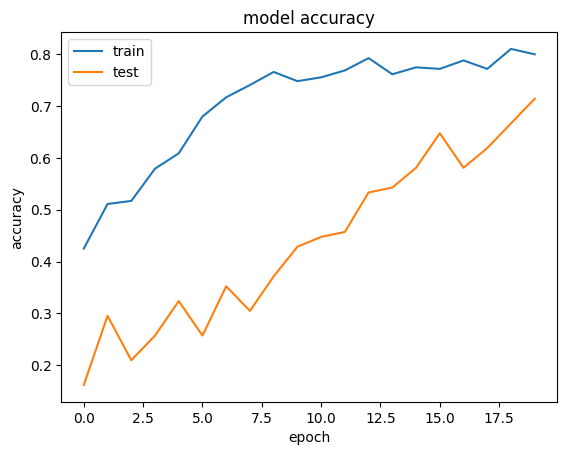

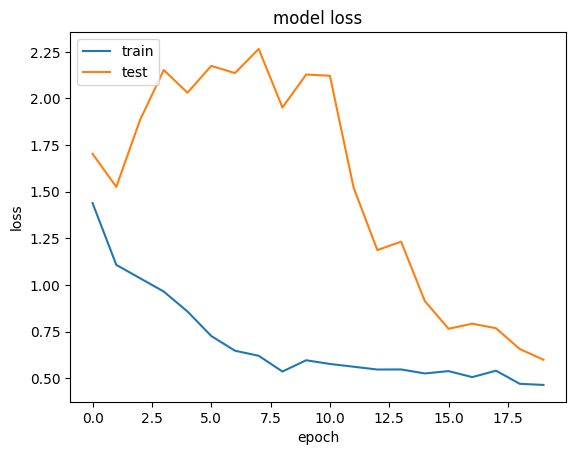

In [ ]:
# summarize history for accuracy
plot(history)

**Experiment - 10 TimeDistributed Conv2D + Dense**

In [ ]:
def conv3D(conv_filters=(16, 32, 64, 128), dense_nodes=(256,128), dropout=0.25, num_images=20, height=120, width=120):
    model = Sequential()
    model.add(TimeDistributed(
        Conv2D(32, (3,3), activation='relu'), input_shape=input_shape)
    )
    model.add(TimeDistributed(
        MaxPooling2D((2,2)))
    )
    model.add(BatchNormalization())

    model.add(TimeDistributed(
        Conv2D(64, (3,3), activation='relu'))
    )
    model.add(TimeDistributed(
        MaxPooling2D((2,2)))
    )
    model.add(BatchNormalization())

    model.add(TimeDistributed(
        Conv2D(128, (3,3), activation='relu'))
    )
    model.add(TimeDistributed(
        MaxPooling2D((2,2)))
    )
    model.add(BatchNormalization())

    model.add(GlobalAveragePooling3D())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(5, activation='softmax'))

    opt = optimizers.Adam(learning_rate=0.002) #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    return model


num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 25 #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model = conv3D(num_images=num_frames)

print (model.summary())

# epochs = 20
# batch size = 25
# num_frames per video = 20
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_30 (TimeDi  (None, 15, 118, 118, 32)  896      
 stributed)                                                      
                                                                 
 time_distributed_31 (TimeDi  (None, 15, 59, 59, 32)   0         
 stributed)                                                      
                                                                 
 batch_normalization_31 (Bat  (None, 15, 59, 59, 32)   128       
 chNormalization)                                                
                                                                 
 time_distributed_32 (TimeDi  (None, 15, 57, 57, 64)   18496     
 stributed)                                                      
                                                           

In [ ]:
callbacks_list = model_callbacks("model_conv3D_1")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size)

val_generator   = generator(val_path, val_doc, batch_size)
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                             callbacks=callbacks_list, validation_data=val_generator,
                             validation_steps=validation_steps, class_weight=None, initial_epoch=0)


Source path =  Project_data/train ; batch size = 25
x: 15  y: 120  z: 120
Epoch 1/20
27/27 [==============================] - ETA: 0s - loss: 1.4338 - categorical_accuracy: 0.4311
Source path =  Project_data/val ; batch size = 25
x: 15  y: 120  z: 120
27/27 [==============================] - 107s 4s/step - loss: 1.4338 - categorical_accuracy: 0.4311 - val_loss: 1.6793 - val_categorical_accuracy: 0.2300 - lr: 0.0020
Epoch 2/20
27/27 [==============================] - 105s 4s/step - loss: 0.9536 - categorical_accuracy: 0.6059 - val_loss: 1.5483 - val_categorical_accuracy: 0.2600 - lr: 0.0020
Epoch 3/20
27/27 [==============================] - 106s 4s/step - loss: 0.7896 - categorical_accuracy: 0.6696 - val_loss: 1.6658 - val_categorical_accuracy: 0.2200 - lr: 0.0020
Epoch 4/20
27/27 [==============================] - 109s 4s/step - loss: 0.7504 - categorical_accuracy: 0.6785 - val_loss: 1.6976 - val_categorical_accuracy: 0.2500 - lr: 0.0020
Epoch 5/20
27/27 [============================

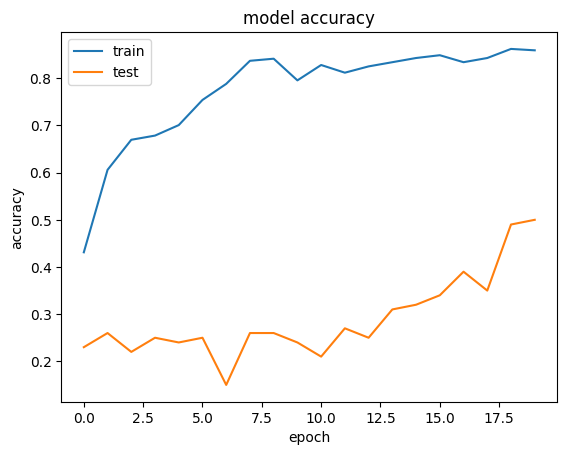

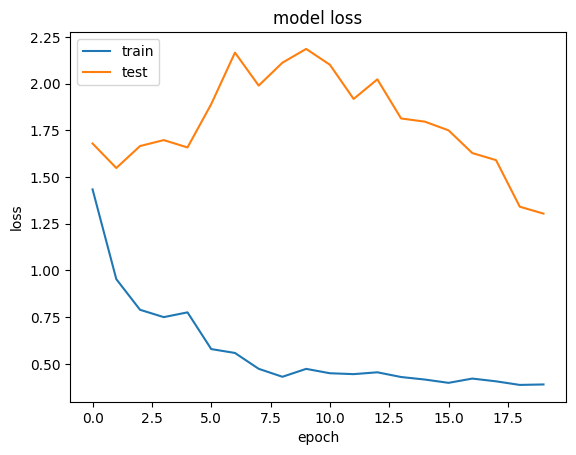

In [ ]:
# summarize history for accuracy
plot(history)

**Experiment - 11 TimeDistributed + ConvLSTM2D**

In [41]:
def conv3D(conv_filters=(16, 32, 64, 128), dense_nodes=(256,128), dropout=0.25, num_images=20, height=120, width=120):
    model = Sequential()
    model.add(TimeDistributed(
        Conv2D(8, (3,3), activation='relu'), input_shape=input_shape)
    )
    model.add(BatchNormalization())
    model.add(TimeDistributed(
        Conv2D(16, (3,3), activation='relu'))
    )
    model.add(BatchNormalization())
    model.add(
        ConvLSTM2D(8, kernel_size = 3, return_sequences=False)
    )
    model.add(BatchNormalization())
    model.add(TimeDistributed(
        Dense(64, activation='relu'))
    )
    model.add(BatchNormalization())
    model.add(GlobalAveragePooling2D())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(5, activation='softmax'))

    opt = optimizers.Adam(learning_rate=0.002) #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    return model


num_epochs = 30 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 15 #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 25
print ('# num_frames per video =', num_frames)

model = conv3D(num_images=num_frames)

print (model.summary())

# epochs = 30
# batch size = 15
# num_frames per video = 25
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_24 (TimeDi  (None, 15, 118, 118, 8)  224       
 stributed)                                                      
                                                                 
 batch_normalization_32 (Bat  (None, 15, 118, 118, 8)  32        
 chNormalization)                                                
                                                                 
 time_distributed_25 (TimeDi  (None, 15, 116, 116, 16)  1168     
 stributed)                                                      
                                                                 
 batch_normalization_33 (Bat  (None, 15, 116, 116, 16)  64       
 chNormalization)                                                
                                                            

In [43]:
callbacks_list = model_callbacks("model_ConvLSTM2D")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generator(train_path, train_doc, batch_size)

val_generator   = generator(val_path, val_doc, batch_size)
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                             callbacks=callbacks_list, validation_data=val_generator,
                             validation_steps=validation_steps, class_weight=None, initial_epoch=0)


Source path =  Project_data/train ; batch size = 15
x: 15  y: 120  z: 120
Epoch 1/30
 8/45 [====>.........................] - ETA: 1:18 - loss: 1.4784 - categorical_accuracy: 0.3667

KeyboardInterrupt: 

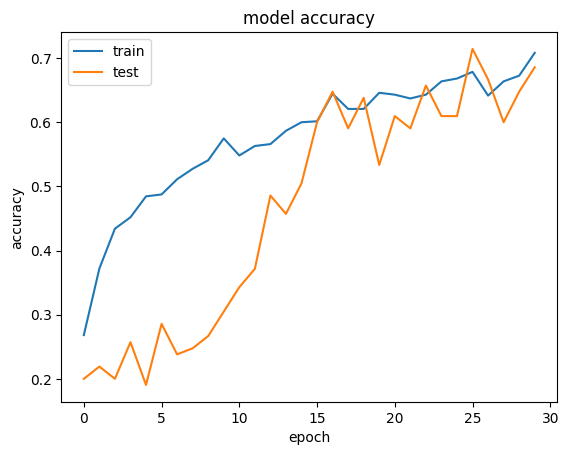

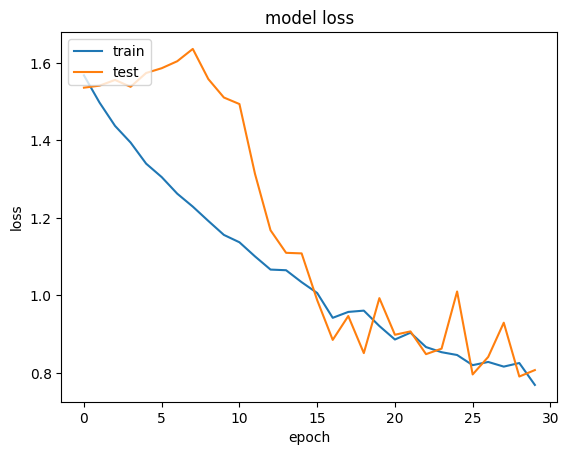

In [ ]:
# summarize history for accuracy
plot(history)